In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

from openpathsampling.analysis.tis_analysis import TISTransition
from openpathsampling.analysis.tis_analysis import sampleset_sample_generator

storage = paths.storage.Storage("_toy_retis.nc", mode="r")

In [2]:
%%time
storage.samples.cache_all()
storage.pathmovechanges.cache_all()

CPU times: user 1.94 s, sys: 363 ms, total: 2.3 s
Wall time: 2.25 s


In [5]:
print len(storage.steps)

2000


In [4]:
retis = storage.transitions.load(0)
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [6]:
%%time
retis.move_summary(storage)

pathreversal ran 24.85% of the cycles with acceptance 394/497 (0.792756539235) 
shooting ran 49.4% of the cycles with acceptance 733/988 (0.741902834008) 
minus ran 1.1% of the cycles with acceptance 22/22 (1.0) 
repex ran 24.65% of the cycles with acceptance 174/493 (0.352941176471) 
CPU times: user 10.6 s, sys: 935 ms, total: 11.6 s
Wall time: 11.4 s


In [7]:
%%time
retis.move_summary(storage, 'shooting')

OneWayShootingMover I'face 0 ran 7.45% of the cycles with acceptance 125/149 (0.838926174497) 
OneWayShootingMover I'face 3 ran 8.2% of the cycles with acceptance 124/164 (0.756097560976) 
OneWayShootingMover I'face 5 ran 8.2% of the cycles with acceptance 110/164 (0.670731707317) 
OneWayShootingMover I'face 1 ran 9.1% of the cycles with acceptance 153/182 (0.840659340659) 
OneWayShootingMover I'face 2 ran 7.4% of the cycles with acceptance 108/148 (0.72972972973) 
OneWayShootingMover I'face 4 ran 9.05% of the cycles with acceptance 113/181 (0.624309392265) 
CPU times: user 492 µs, sys: 113 µs, total: 605 µs
Wall time: 561 µs


In [8]:
retis.rate(storage)

6.805617909429456e-06

In [9]:
def first_n(storage, n, trajid):
    sample_iter = sampleset_sample_generator(storage)
    first = []
    old=None
    for s in sample_iter:
        if s.replica == trajid:
            if s != old:
                first.append(s)
            old = s
        if len(first) == n:
            break
    return first

In [10]:
first40 = first_n(storage, 40, trajid=4)

In [11]:
%%time
from openpathsampling.visualize import PathTreeBuilder
from IPython.display import SVG

tree = PathTreeBuilder(storage)        
tree.rejected = True
tree.from_samples(first40)
view = tree.renderer
view.zoom = 0.8
view.scale_y = 24
view.scale_x = 14
view.font_size = 0.35

CPU times: user 225 ms, sys: 78.7 ms, total: 304 ms
Wall time: 258 ms


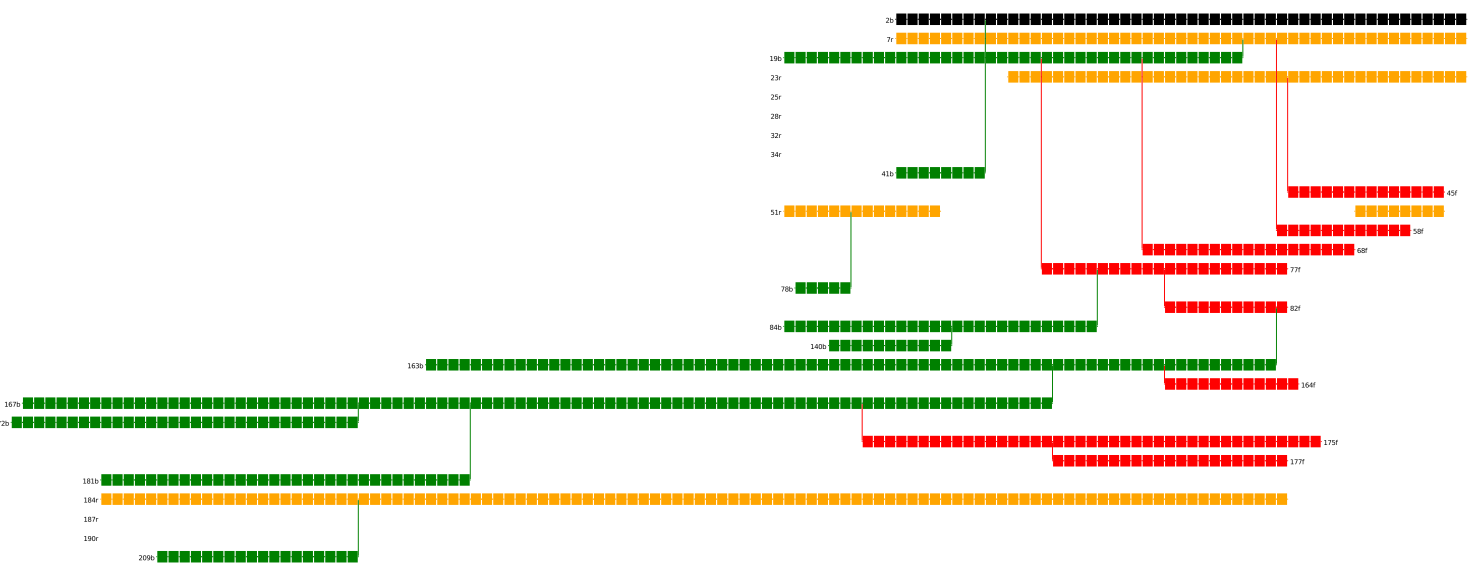

In [12]:
SVG(view.to_svg())

In [13]:
prev = first40[0].trajectory
decorrelated = [prev]
for s in first40:
    if not paths.Trajectory.is_correlated(s.trajectory, prev):
        decorrelated.append(s.trajectory)
        prev = s.trajectory
print "From these samples we have " + str(len(decorrelated)) + " decorrelated trajectories."

From these samples we have 5 decorrelated trajectories.


In [14]:
retis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 150) }
retis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.02, 'bin_range' : (-0.35, 0.35) }

In [15]:
%%time
retis.all_statistics(storage=storage, weights=None, force=True)

CPU times: user 22.5 s, sys: 595 ms, total: 23.1 s
Wall time: 22.7 s


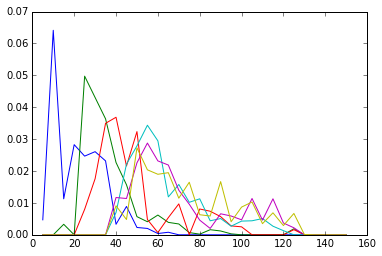

In [16]:
for ens in retis.ensembles:
    myhist = retis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist.normalized())

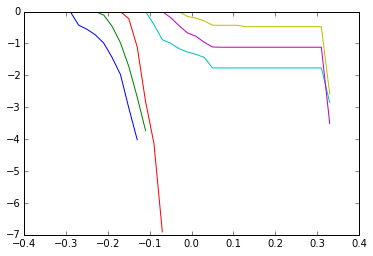

In [17]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), 
             np.log(myhist.reverse_cumulative())
            )

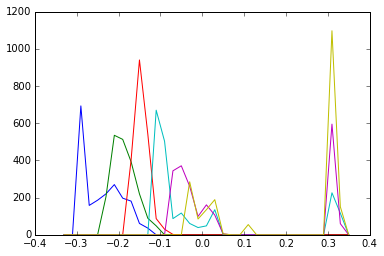

In [18]:
for ens in retis.ensembles:
    myhist = retis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), myhist())

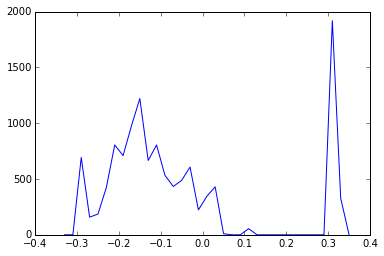

In [19]:
# TODO: add a histogram.sum_hist() function to add several histograms together
from operator import add
total_sampling = np.zeros(len(retis.histograms['max_lambda'][retis.ensembles[0]]()))
for ens in retis.ensembles:
    total_sampling = map(add, total_sampling, retis.histograms['max_lambda'][ens]())
plt.plot(myhist.plot_bins(), total_sampling);

In [20]:
from toy_plot_helpers import ToyPlot
plot = ToyPlot()
plot.add_pes(storage.engines.load(0).pes)

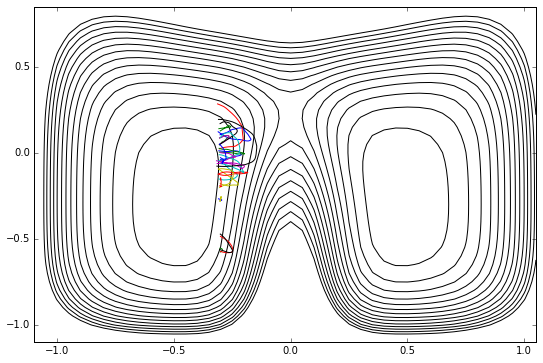

In [21]:
ens0_traj = [s.trajectory for s in storage.samples if s.ensemble == retis.ensembles[0]]
plt.contour(plot.X, plot.Y, plot._pes, levels=np.arange(0.0, 1.5, 0.1), colors='k')
for mytraj in ens0_traj[slice(None,None,15)]:
    plt.plot(mytraj.coordinates()[:,0,0], mytraj.coordinates()[:,0,1])

In [22]:
wham = retis.total_crossing_probability(method="wham")

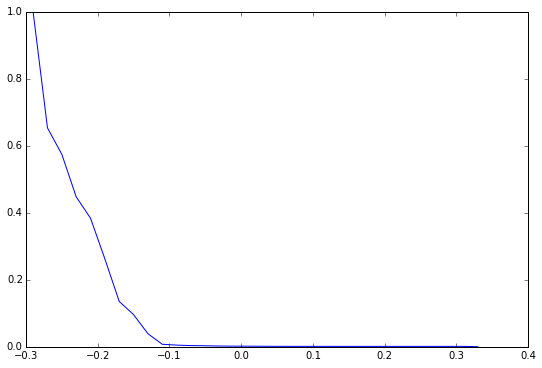

In [23]:
plt.plot(wham.keys(), wham.values());

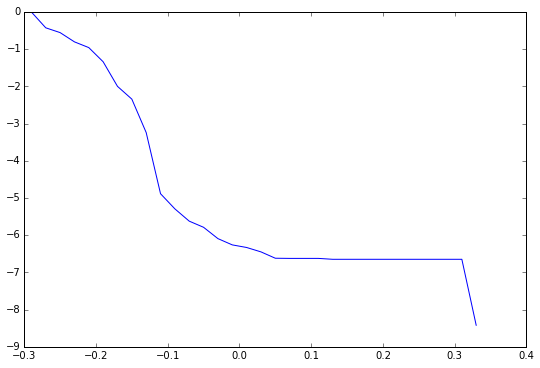

In [24]:
plt.plot(wham.keys(), np.log(wham.values()));

In [25]:
%%time
#retis.rate(storage=storage)
# TODO: conditional_transition_probability, minus_flux, rate
retis.conditional_transition_probability(storage, retis.ensembles[-1])

CPU times: user 1.54 s, sys: 206 ms, total: 1.75 s
Wall time: 1.61 s


0.6233766233766234

In [26]:
retis.minus_move_flux(storage)

0.00356102298478472

In [27]:
print retis._flux, retis.tcp(-0.05), retis.ctp[retis.ensembles[-1]]

0.00356102298478 0.00306578908449 0.623376623377


In [28]:
outer_ens = retis.ensembles[-1]

outer_cross_prob = retis.histograms['max_lambda'][outer_ens]
lambda_bin = -1
while (outer_cross_prob.reverse_cumulative()[lambda_bin+1] == 1.0):
    lambda_bin += 1

outer_cross_lambda = outer_cross_prob.bins[lambda_bin]

In [29]:
retis.rate(storage)

6.805617909429456e-06

6.812935403999999e-06

6.8056179094211644e-06